<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/DRL_portfolio_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



## Python Package Installation

As a first step we check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio


## Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')


import yfinance as yf
from stockstats import StockDataFrame as Sdf
import pyfolio

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3, TRPO
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy


/Users/hongyangyang/anaconda3/lib/python3.6/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)
/Users/hongyangyang/anaconda3/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'
/Users/hongyangyang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hongyangyang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1

# Part 1: Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.

In [ ]:
# Dow 30 constituents at 2019/01/01
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                  'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ',
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']

In [ ]:
# Download and save the data in a pandas DataFrame:
dow_30 = pd.DataFrame()
for tic in dow_30_ticker:
    data_df = yf.download(tic, start="2009-01-01", end="2020-10-23")
    data_df['tic'] = tic
    dow_30=dow_30.append(data_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
dow_30.shape

(89192, 7)

In [ ]:
dow_30.head()

,Open,High,Low,Close,Adj Close,Volume,tic
Date,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.800736,7.460152e+08,AAPL
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.918938,1.181608e+09,AAPL
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.870794,1.289310e+09,AAPL
2009-01-07,3.278929,3.303571,3.223572,3.250357,2.808761,7.530488e+08,AAPL
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.860918,6.735008e+08,AAPL


In [ ]:
# reset the index, we want to use numbers instead of dates
dow_30=dow_30.reset_index()

In [ ]:
# convert the column names to standardized names
dow_30.columns = ['datadate','open','high','low','close','adjcp','volume','tic']

In [ ]:
# convert date to string format, easy to filter
dow_30['datadate']=dow_30.datadate.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.800736,7.460152e+08,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.918938,1.181608e+09,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.870794,1.289310e+09,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,3.250357,2.808761,7.530488e+08,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.860918,6.735008e+08,AAPL


In [ ]:
dow_30.shape

(89192, 8)

# Part 2: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.

## Check missing data

In [ ]:
dow_30.tic.value_counts()

CAT     2975
DIS     2973
MRK     2973
MMM     2973
JNJ     2973
HD      2973
AAPL    2973
KO      2973
INTC    2973
CVX     2973
AXP     2973
NKE     2973
UNH     2973
RTX     2973
VZ      2973
GS      2973
JPM     2973
PFE     2973
PG      2973
DD      2973
IBM     2973
WBA     2973
BA      2973
MSFT    2973
CSCO    2973
V       2973
WMT     2973
MCD     2973
TRV     2973
XOM     2973
Name: tic, dtype: int64

In [ ]:
dow_30=dow_30.dropna()

In [ ]:
# check missing data 
dow_30.isnull().values.any()

False

# Part 3: Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
# divide train and test


In [ ]:
## Environment for Training
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# shares normalization factor
# 100 shares per trade
#HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

REWARD_SCALING = 1e-4


class StockEnvPortfolioTrain(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        self.day = day
        self.df = df

        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (61,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False             
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM 
                      #self.data.macd.values.tolist() + \
                      #self.data.rsi.values.tolist()
                      #self.data.cci.values.tolist() + \
                      #self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        self._seed()

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)

        self.state[index+STOCK_DIM+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_train.csv')

            return self.state, self.reward, self.terminal,{}

        else:
            #actions = actions * HMAX_NORMALIZE
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):61]) 
                    #self.data.macd.values.tolist() + \
                    #self.data.rsi.values.tolist() 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward * REWARD_SCALING
            # print("step_reward:{}".format(self.reward))
            
            self.asset_memory.append(end_total_asset)


        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM 
                      #self.data.macd.values.tolist() + \
                      #self.data.rsi.values.tolist() 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

# Part 4: Implement DRL Algorithms
The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

## Training data split: 2009-01-01 to 2018-12-31

In [ ]:
def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.datadate >= start) & (df.datadate < end)]
    data=data.sort_values(['datadate','tic'],ignore_index=True)
    data.index = data.datadate.factorize()[0]
    return data

In [ ]:
import model.models
from importlib import reload

reload(model.models)
from model.models import *

In [ ]:

## set up train & test environment
# training env
train = data_split(dow_30, start='2009-01-01', end='2019-01-01')

env_train = DummyVecEnv([lambda: StockEnvPortfolioTrain(train)])

In [ ]:
train.tail()

,datadate,open,high,low,close,adjcp,volume,tic
2515,2018-12-31,131.679993,132.440002,130.229996,131.940002,130.493103,7976000.0,V
2515,2018-12-31,55.529999,56.230000,55.070000,56.220001,51.678131,15331800.0,VZ
2515,2018-12-31,68.540001,68.720001,67.739998,68.330002,64.193207,4870900.0,WBA
2515,2018-12-31,92.669998,93.389999,92.250000,93.150002,90.130081,7005800.0,WMT
2515,2018-12-31,68.320000,69.150002,67.660004,68.190002,61.714619,15807000.0,XOM


## Model training: DDPG


In [ ]:
## tensorboard --logdir ./multiple_stock_tensorboard/
#env_train = DummyVecEnv([lambda: StockEnvTrain(train)])
#n_actions = env_train.action_space.shape[-1]
#param_noise = None
#action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

#model_ddpg = DDPG('MlpPolicy', env_train,batch_size=64,buffer_size=100000,param_noise=param_noise, action_noise=action_noise,verbose=0, tensorboard_log="./multiple_stock_3_tensorboard/")
#model_ddpg.learn(total_timesteps=250000, tb_log_name="DDPG_run_1")


In [ ]:
## tensorboard --logdir ./multiple_stock_tensorboard/
# add noise to the action in DDPG helps in learning for better exploration
env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

n_actions = env_train.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model settings
model_ddpg = DDPG('MlpPolicy', 
                   env_train,
                   batch_size=64,
                   buffer_size=100000,
                   param_noise=param_noise, 
                   action_noise=action_noise,
                   verbose=0, 
                   tensorboard_log="./multiple_stock_3_tensorboard/")

## 250k timesteps: took about 20 mins to finish
model_ddpg.learn(total_timesteps=250000, tb_log_name="DDPG_run_1")

previous_total_asset:1000000
end_total_asset:6098490.666340261
total_reward:5098490.666340261
total_cost:  5659.411812112913
total_trades:  35106
Sharpe:  1.2310498862171544
previous_total_asset:1000000
end_total_asset:4726982.713924243
total_reward:3726982.713924243
total_cost:  8009.923747662384
total_trades:  34188
Sharpe:  1.0016067918947542
previous_total_asset:1000000
end_total_asset:5263658.14246378
total_reward:4263658.14246378
total_cost:  4642.337363508471
total_trades:  36858
Sharpe:  1.1451122383973555
previous_total_asset:1000000
end_total_asset:5467182.465760534
total_reward:4467182.465760534
total_cost:  6595.404517323965
total_trades:  34709
Sharpe:  1.1650983580067658
previous_total_asset:1000000
end_total_asset:4347973.050519831
total_reward:3347973.0505198305
total_cost:  7130.57061108519
total_trades:  41260
Sharpe:  1.0330862991593746
previous_total_asset:1000000
end_total_asset:4131403.8638580143
total_reward:3131403.8638580143
total_cost:  14670.709865012392
tota

previous_total_asset:1000000
end_total_asset:4675876.585235974
total_reward:3675876.585235974
total_cost:  11658.495509011393
total_trades:  36941
Sharpe:  0.9083790090068531
previous_total_asset:1000000
end_total_asset:3881668.375579946
total_reward:2881668.375579946
total_cost:  20970.758341836798
total_trades:  38523
Sharpe:  0.8723162006492173
previous_total_asset:1000000
end_total_asset:3339128.901489377
total_reward:2339128.901489377
total_cost:  17492.566812443503
total_trades:  33438
Sharpe:  0.7363829464721616
previous_total_asset:1000000
end_total_asset:4212916.809197426
total_reward:3212916.809197426
total_cost:  9563.048550374497
total_trades:  36166
Sharpe:  0.8933936569660025
previous_total_asset:1000000
end_total_asset:6631699.072553457
total_reward:5631699.072553457
total_cost:  27595.664964718002
total_trades:  41945
Sharpe:  1.1434299418755147
previous_total_asset:1000000
end_total_asset:4441152.922216845
total_reward:3441152.9222168447
total_cost:  28711.647310824188

previous_total_asset:1000000
end_total_asset:4857034.516177365
total_reward:3857034.5161773646
total_cost:  21741.995409269824
total_trades:  43834
Sharpe:  1.142792037107357
previous_total_asset:1000000
end_total_asset:5351915.814690982
total_reward:4351915.814690982
total_cost:  25964.71969999284
total_trades:  41945
Sharpe:  1.0690605255522643
previous_total_asset:1000000
end_total_asset:3751393.27774961
total_reward:2751393.27774961
total_cost:  22005.234680267276
total_trades:  41922
Sharpe:  0.8907483493888233
previous_total_asset:1000000
end_total_asset:3914269.174673166
total_reward:2914269.174673166
total_cost:  36747.737972571835
total_trades:  37028
Sharpe:  0.8650950196572569
previous_total_asset:1000000
end_total_asset:4632114.076595471
total_reward:3632114.0765954712
total_cost:  13321.644823203784
total_trades:  42925
Sharpe:  1.0723797697970365
previous_total_asset:1000000
end_total_asset:3195491.1019952055
total_reward:2195491.1019952055
total_cost:  17589.19926797692


In [ ]:
env_train = DummyVecEnv([lambda: StockEnvPortfolioTrain(train)])
model_a2c = A2C('MlpPolicy', env_train, verbose=0, tensorboard_log="./multiple_stock_3_tensorboard/")
model_a2c.learn(total_timesteps=80000, tb_log_name="A2C_run_1")



previous_total_asset:1000000
end_total_asset:1052423.6303396833
total_reward:52423.630339683266
total_cost:  2951.377566560311
total_trades:  74632
Sharpe:  0.642920834346416
previous_total_asset:1000000
end_total_asset:1057876.1480972995
total_reward:57876.148097299505
total_cost:  2850.8200656060253
total_trades:  72996
Sharpe:  0.370915742567427
previous_total_asset:1000000
end_total_asset:1089739.4843327971
total_reward:89739.48433279712
total_cost:  2474.732659124071
total_trades:  64278
Sharpe:  0.22933509395342777
previous_total_asset:1000000
end_total_asset:1231152.0763314988
total_reward:231152.0763314988
total_cost:  2287.6274228717875
total_trades:  55002
Sharpe:  0.3315870802398701
previous_total_asset:1000000
end_total_asset:1294336.6830964042
total_reward:294336.6830964042
total_cost:  2493.1690291094096
total_trades:  53798
Sharpe:  0.3903021119962256
previous_total_asset:1000000
end_total_asset:1294856.7299866606
total_reward:294856.72998666065
total_cost:  2406.5331121

In [ ]:
env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

model_ppo = PPO2('MlpPolicy', env_train, verbose=0, ent_coef = 0.005, nminibatches = 8, tensorboard_log="./multiple_stock_3_tensorboard/")
model_ppo.learn(total_timesteps=100000, tb_log_name="PPO_run_1")



previous_total_asset:1000000
end_total_asset:2434128.6695674225
total_reward:1434128.6695674225
total_cost:  193605.8995797518
total_trades:  68759
Sharpe:  0.6133805432762075
previous_total_asset:1000000
end_total_asset:3610669.769419623
total_reward:2610669.769419623
total_cost:  210527.28918568886
total_trades:  69122
Sharpe:  0.9979773977871444
previous_total_asset:1000000
end_total_asset:4126741.8011627253
total_reward:3126741.8011627253
total_cost:  187134.5665980503
total_trades:  68376
Sharpe:  1.1090187613808449
previous_total_asset:1000000
end_total_asset:3713726.5405914043
total_reward:2713726.5405914043
total_cost:  149233.90066393986
total_trades:  64258
Sharpe:  1.0668361914707107
previous_total_asset:1000000
end_total_asset:3539346.516110676
total_reward:2539346.516110676
total_cost:  186073.67302040738
total_trades:  67204
Sharpe:  0.955681201144771
previous_total_asset:1000000
end_total_asset:3060852.2754802657
total_reward:2060852.2754802657
total_cost:  166356.243353

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Prepare test data and environment

In [ ]:
# test data
test = data_split(dow_30, start='2019-01-01', end='2020-06-30')
# testing env
env_test = DummyVecEnv([lambda: StockEnvPortfolioTrain(test)])
obs_test = env_test.reset()

### Prediction 

In [ ]:
def DRL_prediction(model, data, env, obs):
    print("==============Model Prediction===========")
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

In [ ]:
# test data
test = data_split(dow_30, start='2019-01-01', end='2020-06-30')
# testing env
env_test = DummyVecEnv([lambda: StockEnvPortfolioTrain(test)])
obs_test = env_test.reset()
DRL_prediction(model=model_a2c, data=test,env=env_test, obs=obs_test)

==============Model Prediction===========
previous_total_asset:1000000
end_total_asset:1031066.5582575875
total_reward:31066.558257587487
total_cost:  690.51431223024
total_trades:  7475
Sharpe:  0.24715030762615972


In [ ]:
0.82
0.75

# Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [ ]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

## Dow Jones Index 

In [ ]:
dji = yf.download("^DJI", start="2019-01-01", end="2020-10-23")
dji=dji.reset_index()
dji.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'adjcp', 'Volume']

[*********************100%***********************]  1 of 1 completed


In [ ]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [ ]:
## get manual results
get_buy_and_hold_sharpe(dji)

annual return:  15.94410351353044
sharpe ratio:  0.5226012140618168


In [ ]:
dji['daily_return']=dji['adjcp'].pct_change(1)

In [ ]:
dow_strat = backtest_strat(dji)

## Our DRL trading strategy

In [ ]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

In [ ]:
## load results
df_account_value = pd.read_csv('results/account_value_trade.csv',index_col=0)
df_account_value = pd.DataFrame({'account_value':df_account_value['0']})


In [ ]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  19.448122377845923
sharpe ratio:  1.0776837918447046


In [ ]:
df_account_value['Date'] = dji['Date']
DRL_strat = backtest_strat(df_account_value)

Start date,2019-01-02
End date,2020-10-22
Total months,21
,Backtest
Annual return,17.789%
Cumulative returns,34.57%
Annual volatility,16.496%
Sharpe ratio,1.08
Calmar ratio,1.39
Stability,0.46
Max drawdown,-12.791%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.79,2020-01-02,2020-02-28,2020-06-05,112
1,12.13,2020-06-08,2020-06-11,NaT,NaN
2,5.55,2019-06-20,2019-08-14,2019-11-26,114
3,2.11,2019-02-28,2019-03-25,2019-04-01,23
4,2.03,2019-11-27,2019-12-03,2019-12-12,12


/Users/hongyangyang/anaconda3/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


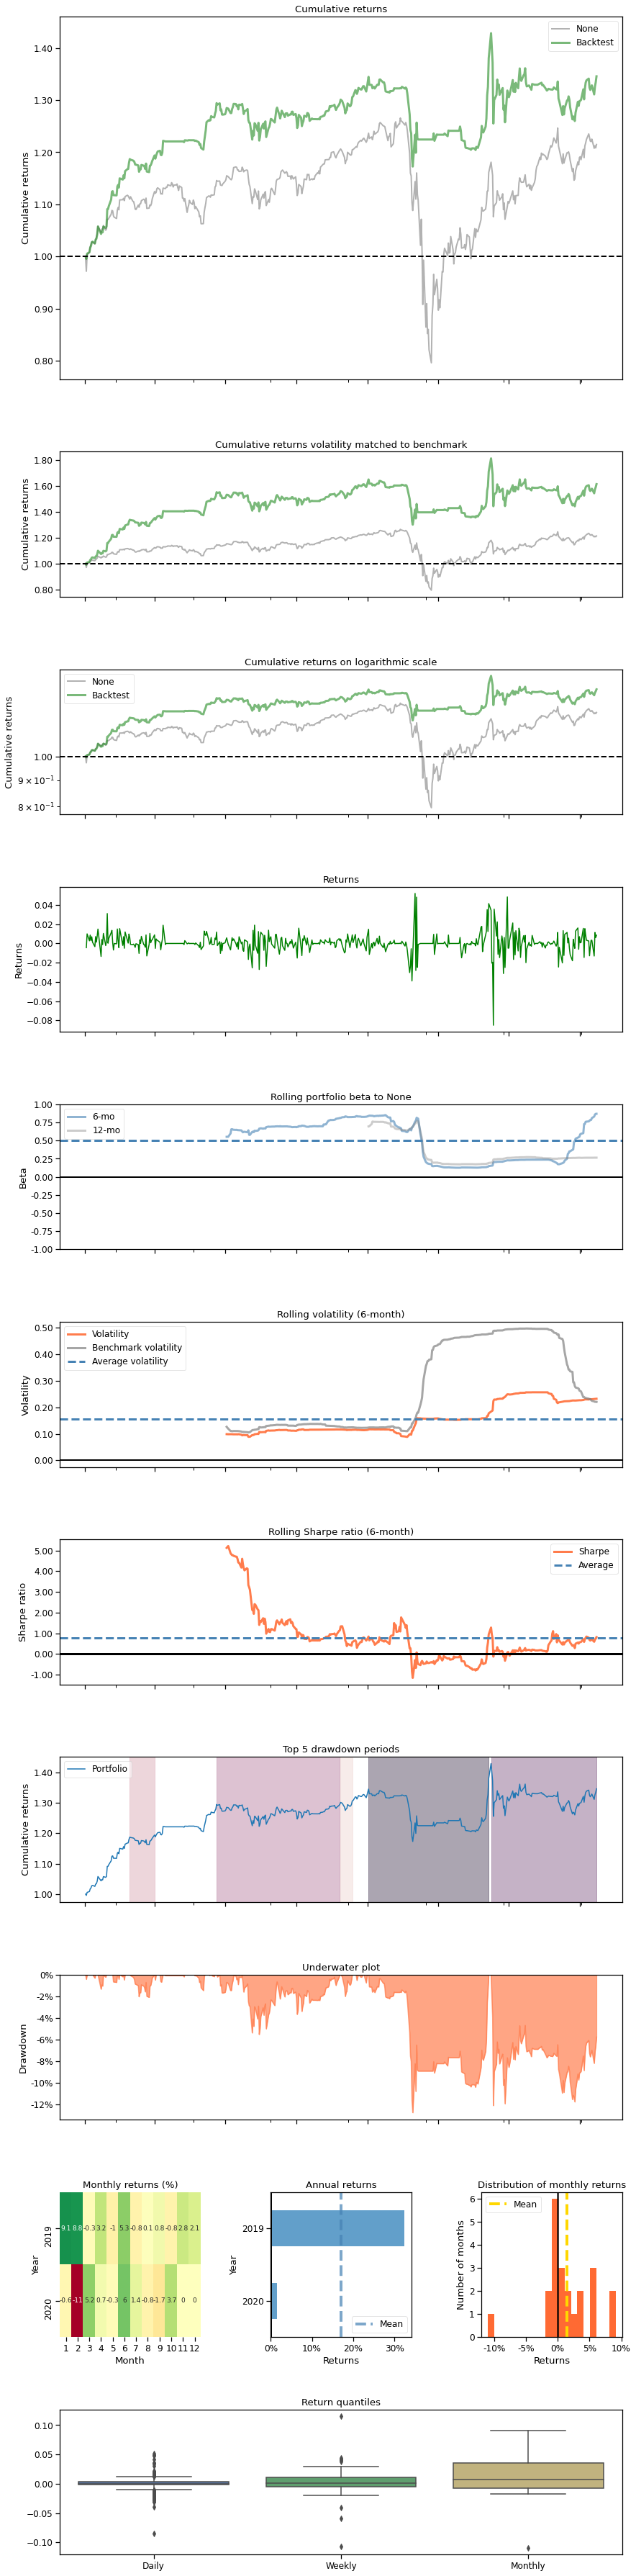

In [ ]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                   benchmark_rets=dow_strat, set_context=False)